In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [2]:
df =  pd.read_csv('../input/yesyes/metres.csv', index_col=[0], parse_dates=[0])

In [3]:
df.head(4)

,KWh
DateTime,
2012-10-12 00:30:00,0.0
2012-10-12 01:00:00,0.0
2012-10-12 01:30:00,0.0
2012-10-12 02:00:00,0.0


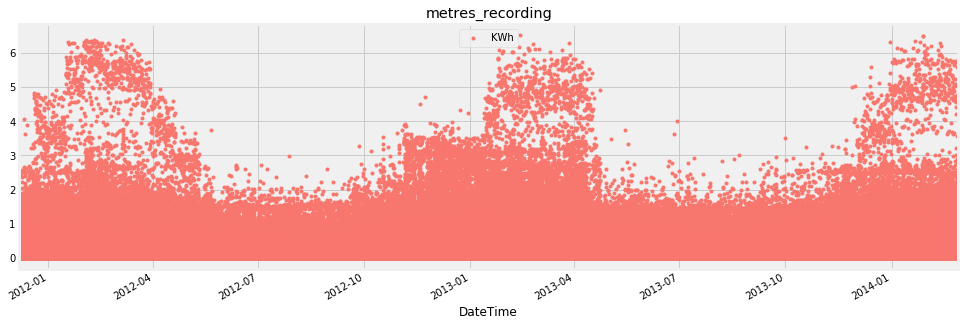

In [4]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = df.plot(style='.', figsize=(15,5), color=color_pal[0], title='metres_recording')

In [5]:
split_date = '01-April-2013'
df_train = df.loc[df.index <= split_date].copy()
df_test = df.loc[df.index > split_date].copy()


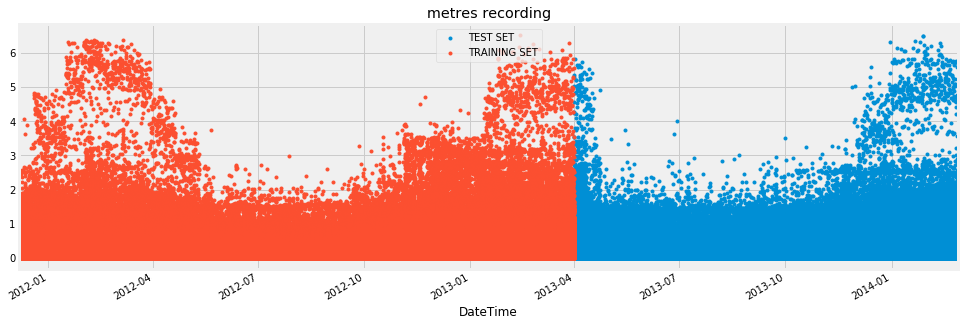

In [6]:
_ = df_test \
    .rename(columns={'KWh': 'TEST SET'}) \
    .join(df_train.rename(columns={'KWh': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='metres recording', style='.')

In [7]:
def create_features(df, label=None):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [8]:
X_train, y_train = create_features(df_train, label='KWh')
X_test, y_test = create_features(df_test, label='KWh')

In [9]:
reg = xgb.XGBRegressor(n_estimators=100)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) 

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[14:02:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

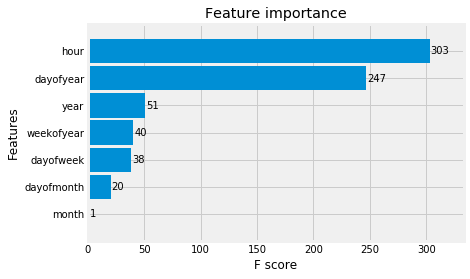

In [10]:
_ = plot_importance(reg, height=0.9)

In [11]:
df_test['KWh_Prediction'] = reg.predict(X_test)
df_all = pd.concat([df_test, df_train], sort=False)

_ = df_all[['KWh','KWh_Prediction']].plot(figsize=(15, 5))


look at first month of prediction

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['KWh_Prediction','KWh']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='04-01-2013', upper='12-01-2013')
ax.set_ylim(0, 60000)
plot = plt.suptitle('Forecast vs Actuals')

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['KWh_Prediction','KWh']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='04-01-2013', upper='12-01-2013')
ax.set_ylim(0, 60000)
plot = plt.suptitle('Forecast vs Actuals')

In [13]:
mean_squared_error(y_true=df_test['KWh'],
                   y_pred=df_test['KWh_Prediction'])

0.1123090363441963

In [14]:
mean_absolute_error(y_true=df_test['KWh'],
                   y_pred=df_test['KWh_Prediction'])

0.20213572054608864